# Evaluation Analysis of Developed Methodology for Trust Estimation

## Libraries

In [1]:
import re
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.patches import FancyArrowPatch
from scipy import stats
from typing import Tuple

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import constants

from optimization import functions

from trusts.model_dynamics import TrustDistribution
from trusts.mle_optimization import MLEOptimization

In [2]:
pd.set_option("display.max_columns",
              None)

## Functions for Plotting

In [3]:
def sorting_key(filename: str) -> list:
    # define a sorting key function using regular expressions
    
    # extract all numeric parts
    parts = re.findall(r'\d+', filename)
    return [int(part) for part in parts]

In [4]:
def plot_beta_distribution(axi: plt,
                           distribution_object: TrustDistribution,
                           trust_label: float,
                           experiment_count: int,
                           title_label_name: str,
                           is_save_fig: bool = False) -> None:
    
    mean_value = distribution_object.get_beta_distribution_mean()
    
    label1 = "Human Trust Model Histogram"
    label2 = "Probability Density Function"
    label3 = "Trust Estimation [Mean Value]"
    label4 = "Trust Measurement [Co-Worker]"
    label5 = f"Absolute Error (%) = {100 * abs(mean_value - trust_label):.1f}"
    
    title_label = f"(\u03B1\u2080={distribution_object.initial_alpha:.1f}; \u03B2\u2080={distribution_object.initial_beta:.1f}; \u03B3={distribution_object.gamma:.4f}; \u03B5={distribution_object.epsilon_reward:.4f}; \u03C9\u02E2={distribution_object.w_success:.4f}; \u03C9\u1da0={distribution_object.w_failure:.4f})"
    
    # generate random samples from the beta distribution
    sample_size = 2000
    samples = stats.beta.rvs(distribution_object.alpha,
                             distribution_object.beta,
                             size=sample_size)

    # plot the histogram of the generated samples
    hist1 = axi.hist(samples,
                     bins=30,
                     density=True,
                     alpha=0.5,
                     color="darkorange",
                     label=label1)

    # plot the probability density function (PDF) of the beta distribution
    x = np.linspace(0, 1, 100)
    pdf = stats.beta.pdf(x,
                         distribution_object.alpha,
                         distribution_object.beta)
    plot1 = axi.plot(x,
                     pdf,
                     color="darkred",
                     linestyle="-",
                     linewidth=3,
                     label=label2)

    # plot the mean value as a horizontal line
    line1 = axi.axvline(x=mean_value,
                        color="darkgreen",
                        linestyle="--",
                        linewidth=3,
                        label=label3)
    
    line2 = axi.axvline(x=trust_label,
                        color="darkblue",
                        linestyle="--",
                        linewidth=2,
                        label=label4)
    
    # check the proximity of mean_value and trust_label
    if mean_value - trust_label < 0.04:

        # if close, adjust the position of the text based on the sign of the difference
        if mean_value > trust_label:
            axi.text(mean_value + 0.008,
                     0.4,
                     f"Estimation: % {100 * mean_value:.1f}",
                     color="darkgreen",
                     fontsize=16,
                     fontweight="bold",
                     rotation=90,
                     ha="left")
        else:
            axi.text(mean_value - 0.004,
                     0.4,
                     f"Estimation: % {100 * mean_value:.1f}",
                     color="darkgreen",
                     fontsize=16,
                     fontweight="bold",
                     rotation=90,
                     ha="right")
    else:
        # adjust the position based on the sign of the difference
        if mean_value > trust_label:
            axi.text(mean_value - 0.006,
                     0.4,
                     f"Estimation: % {100 * mean_value:.1f}",
                     color="darkgreen",
                     fontsize=16,
                     fontweight="bold",
                     rotation=90,
                     ha="right")
        else:
            axi.text(mean_value + 0.03,
                     0.4,
                     f"Estimation: % {100 * mean_value:.1f}",
                     color="darkgreen",
                     fontsize=16,
                     fontweight="bold",
                     rotation=90,
                     ha="left")
    
    axi.text(trust_label - 0.04,
             0.4,
             f"Measurement: % {100 * trust_label:.1f}",
             color="darkblue",
             fontsize=16,
             fontweight="bold",
             rotation=90,
             ha="left")
    
    # create an arrow between mean_value and trust_label
    arrow_params = {
        "arrowstyle": "<|-|>",
        "mutation_scale": 15,
        "color": "black",
        "linewidth": 2,
        "label": label5
    }
    axi.annotate("",
                 xy=(mean_value, 0.07),
                 xytext=(trust_label, 0.07),
                 arrowprops=arrow_params)
    arrow_legend = FancyArrowPatch((0, 0),
                                   (1, 0),
                                   **arrow_params)
    
    if mean_value <= 0.5:
        anchor_posx, anchor_posy = 1.0, 1.0
    else:
        anchor_posx, anchor_posy = 0.65, 1.0
    
    legend = axi.legend(handles=[hist1[2][0], plot1[0], line1, line2, arrow_legend],
                        labels=[label1, label2, label3, label4, label5],
                        loc="upper right",
                        bbox_to_anchor=(anchor_posx, anchor_posy),
                        fancybox=True,
                        shadow=True,
                        fontsize=14,
                        title=f"{title_label_name} Experiment {experiment_count}",
                        title_fontsize="12")
    legend.get_title().set_fontweight("bold")

    # format x-axis ticks as percentages
    axi.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{100 * x:.0f}%'))
    # set x-axis ticks at every 10 percent
    axi.set_xticks(np.arange(0, 1.1, 0.1))
    axi.tick_params(axis="x",
                    labelsize=14)
    
    axi.set_title(title_label,
                  fontsize=14)
    axi.set_xlabel(f"Trust Estimation (%) - Beta Distribution (\u03B1={distribution_object.alpha:.1f}; \u03B2={distribution_object.beta:.1f})",
                   fontsize=16)
    axi.set_ylabel("Probability Density Function (pdf)",
                   fontsize=16)
    ax.grid(True,
            which="both",
            axis="x",
            linestyle="--",
            color="grey",
            alpha=0.7,
            linewidth=0.5)

    if is_save_fig:
        plt.savefig(f"{title_label_name}_experiment_{experiment_count}_trust_distribution.png",
                    dpi=600,
                    bbox_inches="tight",
                    transparent=True)
    
    plt.show()

In [5]:
def run_through_trajectory(df: pd.DataFrame,
                           column_names: list,
                           distribution_object: TrustDistribution) -> Tuple[pd.DataFrame,
                                                                            TrustDistribution]:
    
    # create a column to store estimated trust values; initialize it to zero as a default value
    for column in column_names[:-1]:
        df[column] = 0.0
    
    # create columns for quantile values to represent variance (%5 min and %95 )
    df["TrustEstimationQ5"] = 0.0
    df["TrustEstimationQ95"] = 0.0
    
    reward_array = df["Reward"].to_numpy()
    
    # update distribution parameters (alpha and beta) with current success and failure weights
    for idx, reward in enumerate(reward_array):
        distribution_object.update_parameters(performance=reward)
        
        # store all important parameters in the dataframe
        df.at[idx, column_names[0]] = distribution_object.alpha
        df.at[idx, column_names[1]] = distribution_object.beta
        df.at[idx, column_names[2]] = distribution_object.initial_alpha
        df.at[idx, column_names[3]] = distribution_object.initial_beta
        df.at[idx, column_names[4]] = distribution_object.w_success
        df.at[idx, column_names[5]] = distribution_object.w_failure
        df.at[idx, column_names[6]] = distribution_object.gamma
        df.at[idx, column_names[7]] = distribution_object.epsilon_reward
        
        # calculate and store estimated trust value only after the reward is obtained
        trust_estimation = distribution_object.get_beta_distribution_mean()
        df.at[idx, column_names[8]] = trust_estimation
        
        # store %5 and %95 quantile values of the distribution
        df.at[idx, "TrustEstimationQ5"] = distribution_object.distribution.ppf(0.05)
        df.at[idx, "TrustEstimationQ95"] = distribution_object.distribution.ppf(0.95)
    
    return df, distribution_object

## Initialization

In [6]:
configs = functions.setup_config(device="cpu")

Current Time:  Mar_15_2024-01_50_48


## Create Beta Distribution Object to Resembe Trust

In [7]:
trust_obj = TrustDistribution(initial_alpha=configs.initial_alpha,
                              initial_beta=configs.initial_beta,
                              gamma=configs.gamma,
                              initial_w_success=configs.initial_w_success,
                              initial_w_failure=configs.initial_w_failure,
                              epsilon_reward=configs.epsilon_reward)

## Read Robot Experiment Outputs

In [8]:
_, results_path = functions.get_directories(parent_directory=parent_directory,
                                            data_folder_name="")
experiments_folder_path = os.path.join(results_path,
                                       "experiments")

In [9]:
# learning trust behavior stage experiments and results
learning_data_folder_path = os.path.join(experiments_folder_path,
                                         constants.LEARNING_EXPERIMENT_FOLDER)
if os.path.exists(learning_data_folder_path):
    learning_excel_files = os.listdir(learning_data_folder_path)
else:
    print("NOTE: learning experiments are not saved @: ", learning_data_folder_path)

# sort the file list using the custom sorting key
learning_excel_files = sorted(learning_excel_files,
                              key=sorting_key)

In [10]:
# inference stage experiments and results
inference_data_folder_path = os.path.join(experiments_folder_path,
                                    constants.INFERENCE_EXPERIMENT_FOLDER)
if os.path.exists(inference_data_folder_path):
    inference_excel_files = os.listdir(inference_data_folder_path)
else:
    print("NOTE: Inference experiments are not saved @: ", inference_data_folder_path)

# sort the file list using the custom sorting key
inference_excel_files = sorted(inference_excel_files,
                               key=sorting_key)

## Read Human Trust Measurement Labels

In [11]:
learning_trust_labels_list = []
for learning_file_name in learning_excel_files:
    trust_match = re.search(r"trust_(\d+)",
                            learning_file_name)
    if trust_match:
        learning_trust_labels_list.append(int(trust_match.group(1)))

In [12]:
inference_trust_labels_list = []
for inference_file_name in inference_excel_files:
    trust_match = re.search(r"trust_(\d+)",
                            inference_file_name)
    if trust_match:
        inference_trust_labels_list.append(int(trust_match.group(1)))

## Define Constant Parameter List

In [13]:
# Do Not Change Order
prior_columns = ["TimeStep",
                 "StateNorm1", "StateNorm2", "StateNorm3",
                 "Reward"]
column_names = ["Alpha", "Beta",
                "Alpha0", "Beta0",
                "SuccessWeight", "FailureWeight",
                "Gamma", "EpsilonReward",
                "TrustEstimation", "TrustLabel"]

## Run Through Learning Trust Behavior Experiments

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


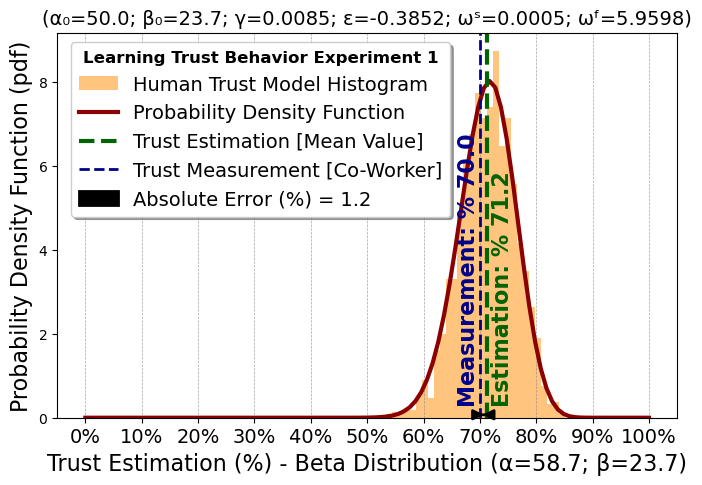

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


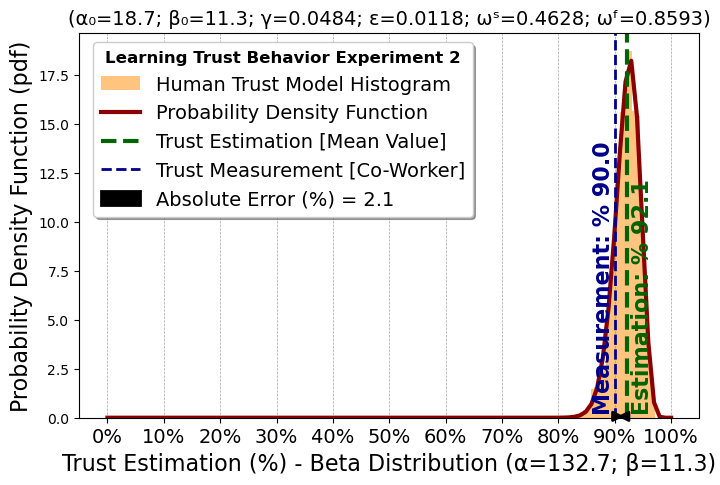

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
c:\users\24989903\research-uts\codes\learning-trust-behavior\src\trusts\mle_optimization.py:70: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(beta_distribution.pdf(trust_label,


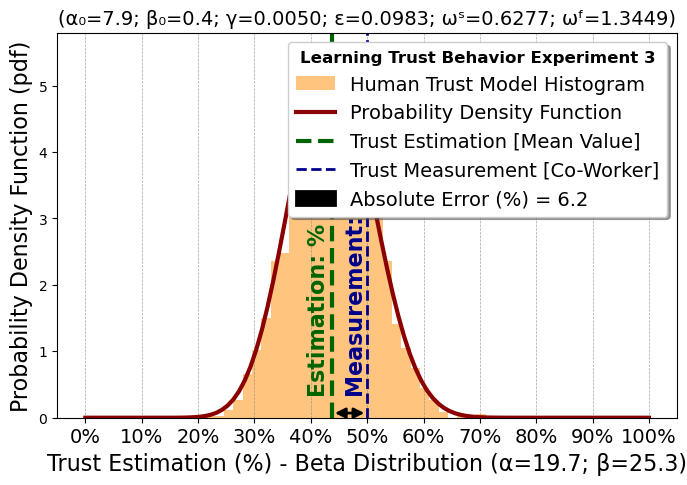

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


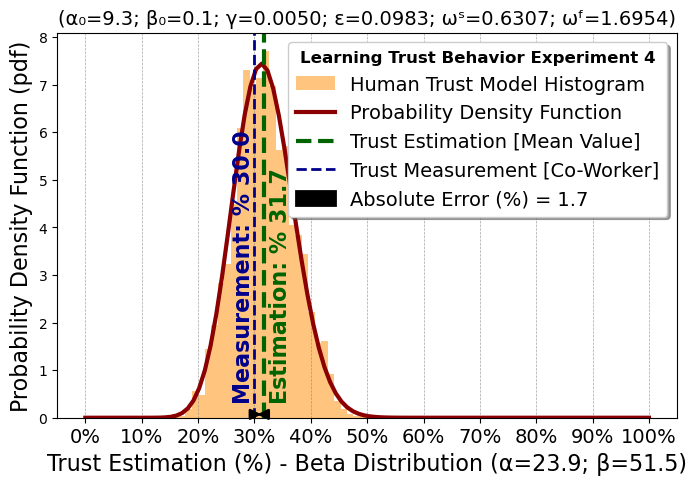

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


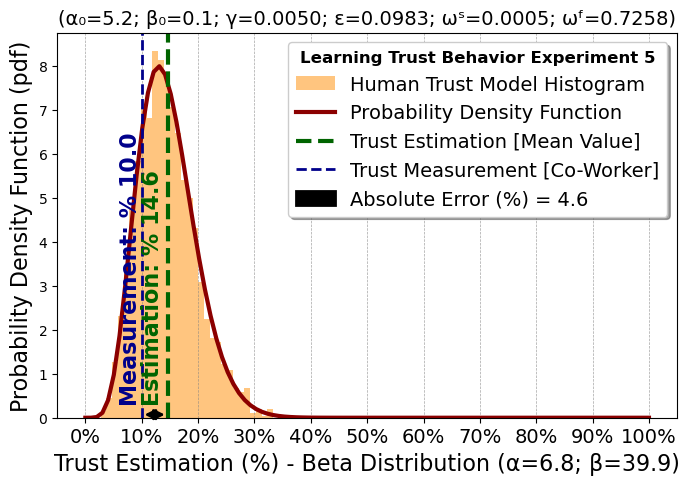

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
c:\users\24989903\research-uts\codes\learning-trust-behavior\src\trusts\mle_optimization.py:70: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(beta_distribution.pdf(trust_label,


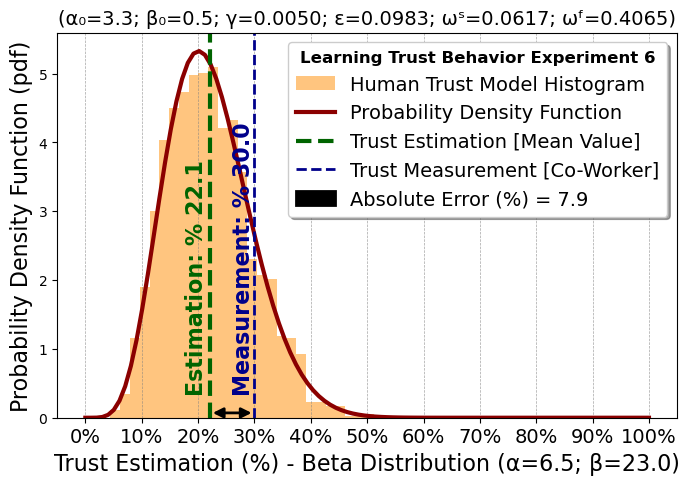

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


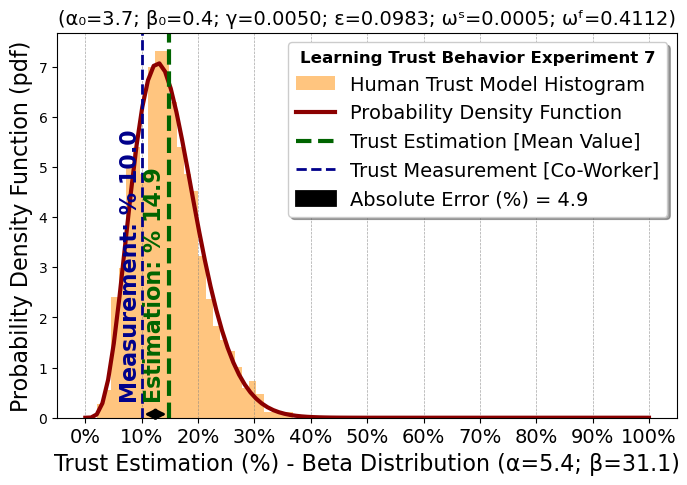

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


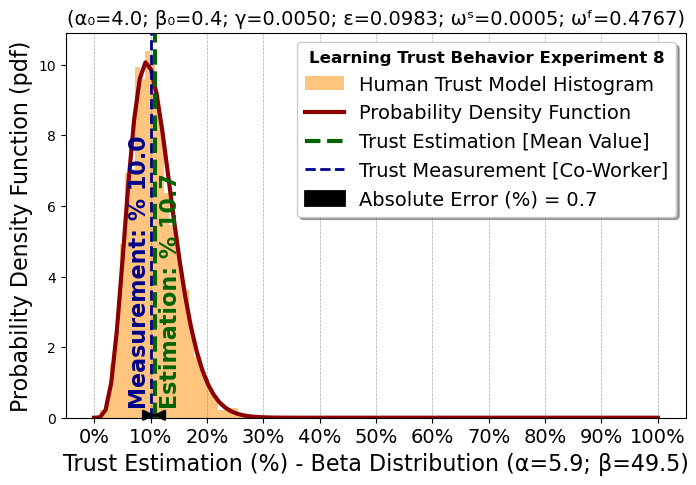

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
c:\users\24989903\research-uts\codes\learning-trust-behavior\src\trusts\mle_optimization.py:70: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(beta_distribution.pdf(trust_label,


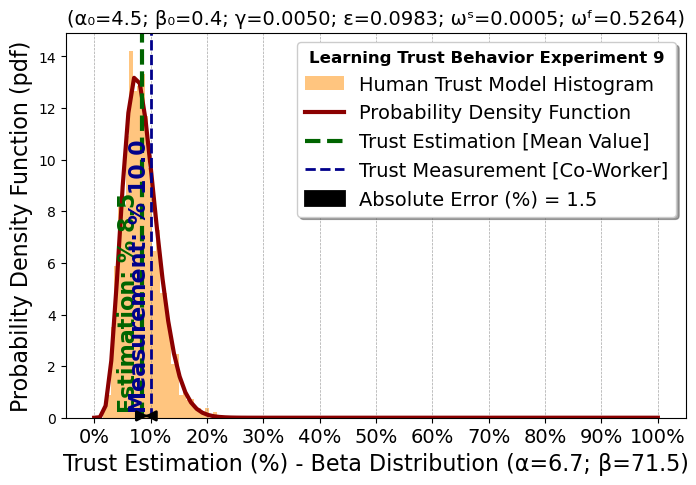

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


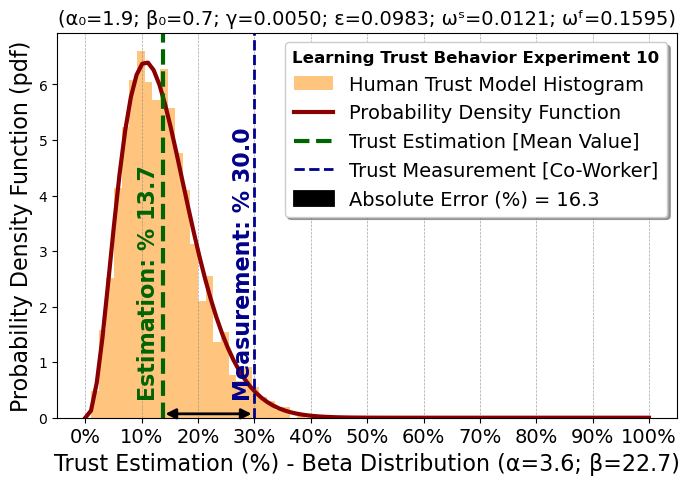

In [14]:
# in learning trust behavior, the following will be updated:
# alpha, beta, alpha_0, beta_0, w_success, w_failure, gamma, eplison_reward
learning_df = pd.DataFrame(columns=["Experiment"] + prior_columns + column_names)

initial_alpha = 0.5
initial_beta = 0.5
w_success = 0.2
w_failure = 0.2
gamma = 0.1
epsilon_reward = 0.1

for idx, learning_excel in enumerate(learning_excel_files):
    learn_df = pd.read_excel(os.path.join(learning_data_folder_path,
                                             learning_excel))
    
    # measured trust value of the particular experiment (measured at the end of the experiment)
    trust_label = learning_trust_labels_list[idx]
    true_trust = trust_label / 100 # from percentage to range [0, 1]
    
    # store measured trust
    learn_df[column_names[9]] = true_trust
    
    # save referring index of the experiment
    learn_df["Experiment"] = idx + 1
    
    # collect all dataframes for validation
    if len(learning_df) == 0: learning_df = learn_df
    else: learning_df = pd.concat([learning_df, learn_df],
                                  axis=0,
                                  ignore_index=True)
    del learn_df
    
    # optimization object for maximum likelihood estimation (MLE)
    mle_obj = MLEOptimization(learning_experiment_data=learning_df,
                              seed=constants.RANDOM_SEED)
    
    # run optimization
    trust_obj, initial_alpha, initial_beta, w_success, w_failure, gamma, epsilon_reward = mle_obj.fit([initial_alpha,
                                                                                                       initial_beta,
                                                                                                       w_success,
                                                                                                       w_failure,
                                                                                                       gamma,
                                                                                                       epsilon_reward])

    # store important data related to the plotting of the distribution
    learning_df.loc[learning_df["Experiment"] == idx + 1, column_names[0]] = trust_obj.alpha
    learning_df.loc[learning_df["Experiment"] == idx + 1, column_names[1]] = trust_obj.beta
    learning_df.loc[learning_df["Experiment"] == idx + 1, column_names[2]] = trust_obj.initial_alpha
    learning_df.loc[learning_df["Experiment"] == idx + 1, column_names[3]] = trust_obj.initial_beta
    learning_df.loc[learning_df["Experiment"] == idx + 1, column_names[4]] = trust_obj.w_success
    learning_df.loc[learning_df["Experiment"] == idx + 1, column_names[5]] = trust_obj.w_failure
    learning_df.loc[learning_df["Experiment"] == idx + 1, column_names[6]] = trust_obj.gamma
    learning_df.loc[learning_df["Experiment"] == idx + 1, column_names[7]] = trust_obj.epsilon_reward
    
    # plot estimation, label, error in the trust distribution
    fig, ax = plt.subplots(1, 1,
                           figsize=(8, 5))
    plot_beta_distribution(axi=ax,
                           distribution_object=trust_obj,
                           trust_label=true_trust,
                           experiment_count=idx + 1,
                           title_label_name="Learning Trust Behavior",
                           is_save_fig=True)

In [15]:
learning_df

,TimeStep,StateNorm1,StateNorm2,StateNorm3,Reward,TrustLabel,Experiment,Alpha,Beta,Alpha0,Beta0,SuccessWeight,FailureWeight,Gamma,EpsilonReward
0,1,0.278327,0.663454,0.350482,0.084249,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
1,2,0.378778,0.606984,0.431282,0.098223,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
2,3,0.379403,0.597494,0.422197,0.111344,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
3,4,0.370923,0.587694,0.415961,0.126263,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
4,5,0.359647,0.576191,0.410865,0.143303,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,16,0.226689,0.133116,0.165072,0.448209,0.3,10,3.601348,22.673295,1.887963,0.652891,0.012129,0.159466,0.005000,0.098270
196,17,0.229380,0.131001,0.162676,0.448294,0.3,10,3.601348,22.673295,1.887963,0.652891,0.012129,0.159466,0.005000,0.098270
197,18,0.231157,0.129648,0.161093,0.448349,0.3,10,3.601348,22.673295,1.887963,0.652891,0.012129,0.159466,0.005000,0.098270
198,19,0.232309,0.128790,0.160067,0.448341,0.3,10,3.601348,22.673295,1.887963,0.652891,0.012129,0.159466,0.005000,0.098270


In [16]:
learning_df.to_excel("learning_stage_experiment_results.xlsx",
                     index=False)

## Run Through Inference Experiments After Tuning Beta Distribution Parameters

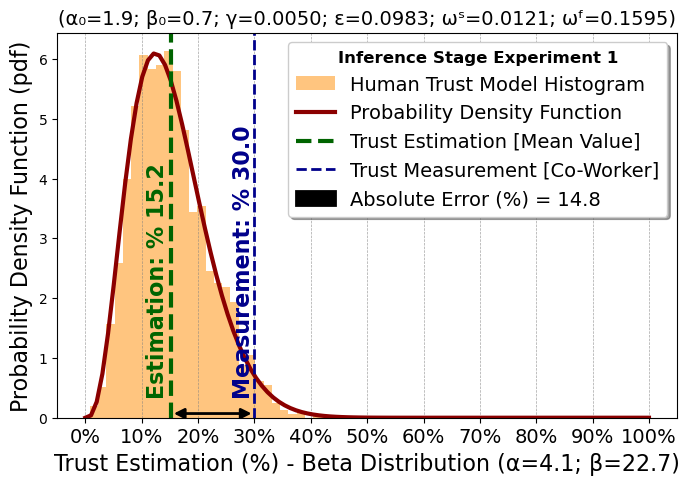

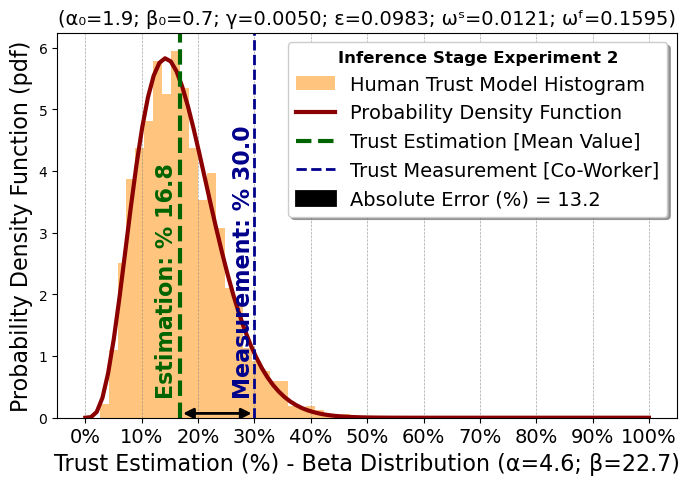

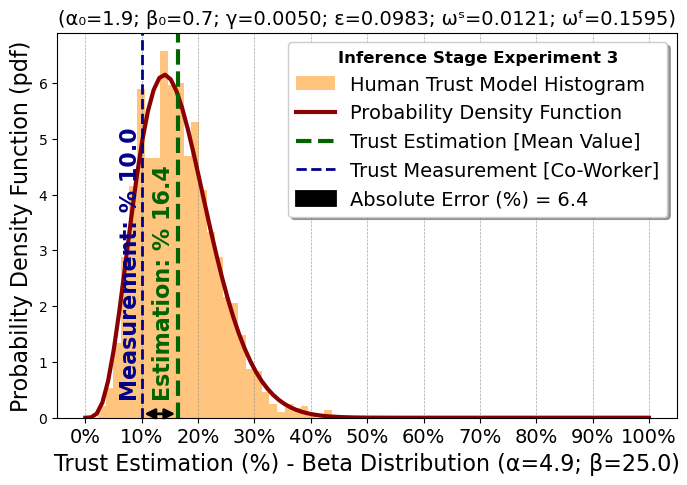

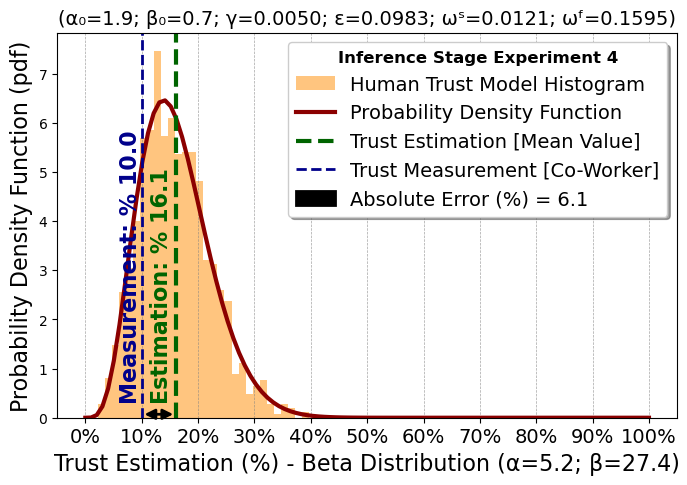

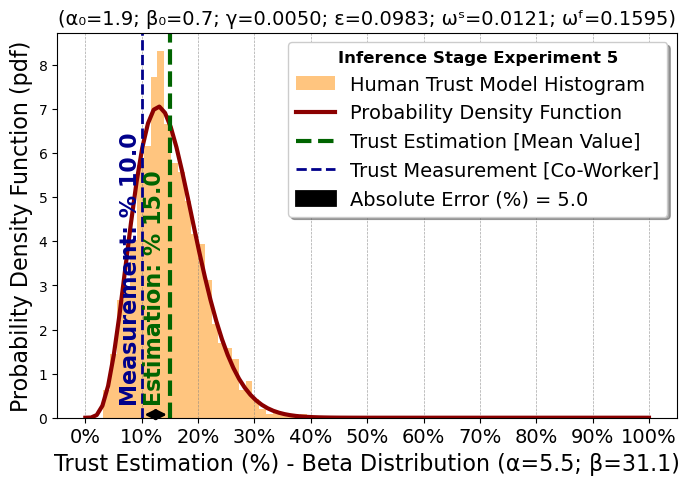

In [17]:
# in learning trust behavior, the following will be constant:
# alpha_0, beta_0, w_success, w_failure, gamma, epsilon_reward
INFERENCE_df = pd.DataFrame(columns=["Experiment"] + prior_columns + column_names)

for idx, inference_excel in enumerate(inference_excel_files):
    inference_df = pd.read_excel(os.path.join(inference_data_folder_path,
                                              inference_excel))
    
    # measured trust value of the particular experiment (measured at the end of the experiment)
    trust_label = inference_trust_labels_list[idx]
    true_trust = trust_label / 100 # from percentage to range [0, 1]
    
    # store measured trust
    inference_df[column_names[9]] = true_trust
    
    # save referring index of the experiment
    inference_df["Experiment"] = idx + 1
    
    # by running the following, only alpha and beta parameters will be updated
    inference_df, trust_obj = run_through_trajectory(df=inference_df,
                                                     column_names=column_names,
                                                     distribution_object=trust_obj)
    
    # collect all dataframes
    if len(inference_df) == 0:
        INFERENCE_df = inference_df
    else:
        INFERENCE_df = pd.concat([INFERENCE_df, inference_df], axis=0, ignore_index=True)
    
    # plot estimation, label, error in the trust distribution
    fig, ax = plt.subplots(1, 1,
                           figsize=(8, 5))
    plot_beta_distribution(axi=ax,
                           distribution_object=trust_obj,
                           trust_label=true_trust,
                           experiment_count=idx + 1,
                           title_label_name="Inference Stage",
                           is_save_fig=True)

In [18]:
INFERENCE_df

,Experiment,TimeStep,StateNorm1,StateNorm2,StateNorm3,Reward,Alpha,Beta,Alpha0,Beta0,SuccessWeight,FailureWeight,Gamma,EpsilonReward,TrustEstimation,TrustLabel,TrustEstimationQ5,TrustEstimationQ95
0,1,1,0.175484,0.663454,0.350482,0.115040,3.620722,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.137701,0.3,0.046889,0.260109
1,1,2,0.340628,0.576167,0.426812,0.142809,3.640551,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.138351,0.3,0.047311,0.260909
2,1,3,0.342571,0.562095,0.410751,0.162741,3.660719,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.139011,0.3,0.047740,0.261721
3,1,4,0.329712,0.546856,0.400674,0.185648,3.681265,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.139682,0.3,0.048178,0.262545
4,1,5,0.312151,0.528676,0.392526,0.211976,3.702231,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.140366,0.3,0.048626,0.263384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,16,0.348435,0.564925,0.406291,0.159794,5.359499,31.124042,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.146902,0.1,0.063937,0.252041
96,5,17,0.333147,0.549635,0.400350,0.181958,5.388494,31.124042,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.147579,0.1,0.064432,0.252842
97,5,18,0.315372,0.531767,0.393393,0.207640,5.417944,31.124042,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.148266,0.1,0.064935,0.253653
98,5,19,0.294724,0.510852,0.385210,0.237009,5.447896,31.124042,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.148964,0.1,0.065447,0.254475


In [19]:
INFERENCE_df.to_excel("inference_stage_experiment_results.xlsx",
                      index=False)